# 1-Load Data

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf 
import keras
import os 
import cv2
import warnings
warnings.filterwarnings("ignore")

2024-05-15 02:38:10.181118: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-15 02:38:10.181227: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-15 02:38:10.311495: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
class_names = ['buildings','forest','glacier','mountain','sea','street']
class_labels = {class_name:i for i,class_name in enumerate(class_names)}

image_size = (150,150) 
class_labels

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [3]:
def load_data():
    
    datasets = ['/kaggle/input/intel-image-classification/seg_train/seg_train',
                '//kaggle/input/intel-image-classification/seg_test/seg_test']
    
    output = []
    
    # Iterate through train and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            
            label = class_labels[folder]
            
            # Iterate through each image in our folder
            for file in os.listdir(os.path.join(dataset,folder)):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset,folder),file)
                
                 #Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                image = cv2.resize(image , image_size)
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
                
        images = np.array(images , dtype='float32')
        labels = np.array(labels , dtype='int32')
        
        
        output.append((images,labels))
        
    return output

In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data()

In [5]:
print('shape of train images ',train_images.shape)
print('shape of train labels ' ,train_labels.shape)
print('shape of test images ',test_images.shape)
print('shape of test labels ' ,test_labels.shape)

shape of train images  (14034, 150, 150, 3)
shape of train labels  (14034,)
shape of test images  (3000, 150, 150, 3)
shape of test labels  (3000,)


We have 14034 images for training , 3000 images for testing , each size of image is 150x150 and each image is RGB

In [6]:
# Normalize data
train_images = train_images / 255.0 
test_images = test_images / 255.0

In [7]:
from sklearn.utils import shuffle 
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

# 2-Data Visualizations

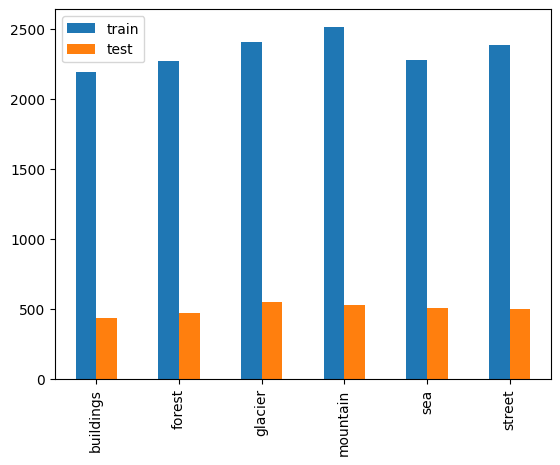

In [8]:
# checking balancing for data

_,train_counts = np.unique(train_labels, return_counts=True)
_,test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

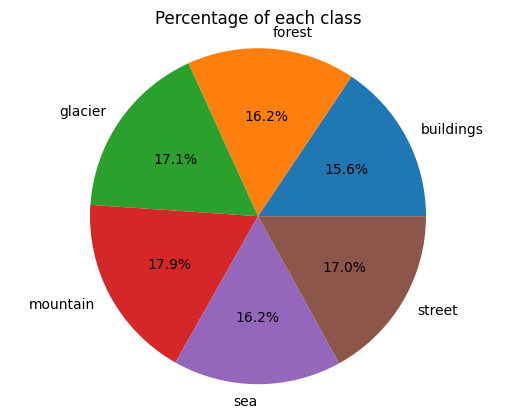

In [9]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Percentage of each class')
plt.show()

label is : 3


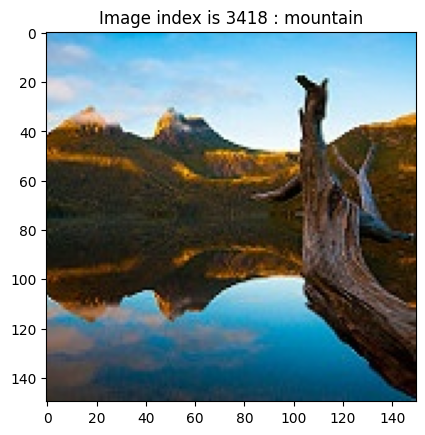

In [10]:
i = np.random.randint(train_images.shape[0])
plt.imshow(tf.reshape(train_images[i],[150,150,3]))
plt.title('Image index is {} : '.format(i) + class_names[train_labels[i]])
print('label is :',train_labels[i])


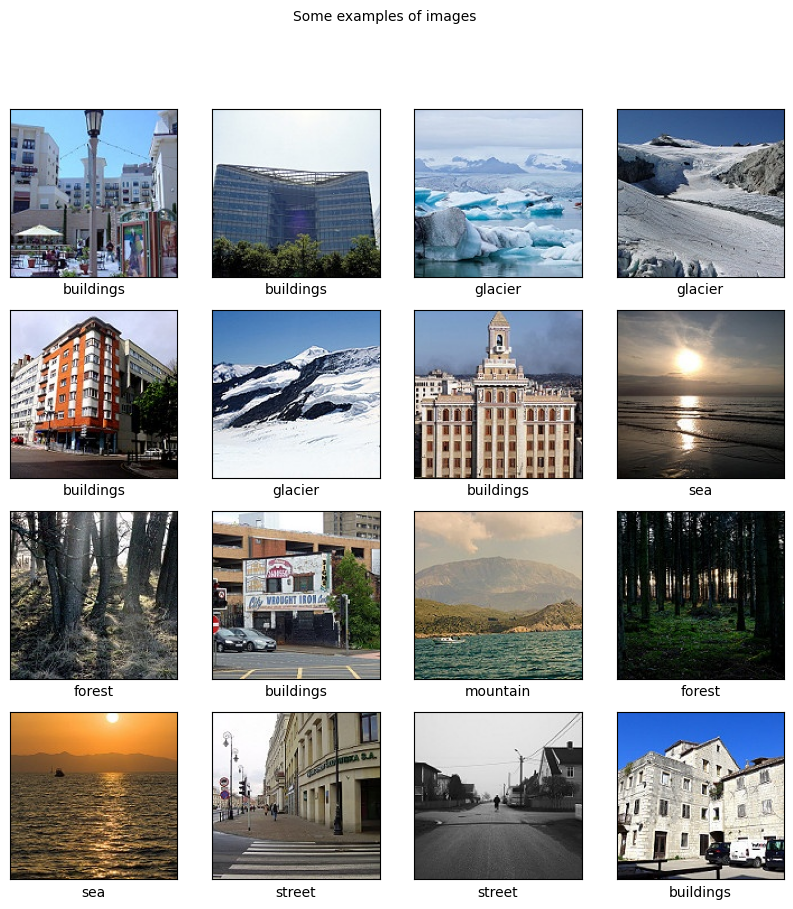

In [11]:
fig = plt.figure(figsize=(10,10))
fig.suptitle("Some examples of images", fontsize=10)
for i in range(16):
        plt.subplot(4,4,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_images[i],cmap=plt.cm.binary)
        plt.xlabel(class_names[train_labels[i]])
plt.show()

# 3-Model

In [12]:
model = keras.models.Sequential([
        keras.layers.Conv2D(200,kernel_size=(3,3),activation='relu',input_shape=(150,150,3)),
        keras.layers.Conv2D(150,kernel_size=(3,3),activation='relu'),
        keras.layers.MaxPool2D(4,4),
        keras.layers.Conv2D(120,kernel_size=(3,3),activation='relu'),    
        keras.layers.Conv2D(80,kernel_size=(3,3),activation='relu'),    
        keras.layers.Conv2D(50,kernel_size=(3,3),activation='relu'),
        keras.layers.MaxPool2D(4,4),
        keras.layers.Flatten() ,    
        keras.layers.Dense(120,activation='relu') ,    
        keras.layers.Dense(100,activation='relu') ,    
        keras.layers.Dense(50,activation='relu') ,        
        #keras.layers.Dropout(rate=0.5) ,            
        keras.layers.Dense(6,activation='softmax') ,    
    
        ])



In [13]:
model.compile(optimizer='adam' , loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
history = model.fit(train_images, train_labels, batch_size=100, epochs=50, validation_split = 0.2)

Epoch 1/50


2024-05-15 02:40:43.132999: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=4,k3=0} for conv (f32[100,150,146,146]{3,2,1,0}, u8[0]{0}) custom-call(f32[100,200,148,148]{3,2,1,0}, f32[150,200,3,3]{3,2,1,0}, f32[150]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-05-15 02:40:43.183341: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.050497565s
Trying algorithm eng11{k2=4,k3=0} for conv (f32[100,150,146,146]{3,2,1,0}, u8[0]{0}) custom-call(f32[100,200,148,148]{3,2,1,0}, f32[150,200,3,3]{3,2,1,0}, f32[150]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a 

112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.3938 - loss: 1.4357

2024-05-15 02:43:13.761445: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[150,200,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[27,200,148,148]{3,2,1,0}, f32[27,150,146,146]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-05-15 02:43:18.709836: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 5.948511601s
Trying algorithm eng0{} for conv (f32[150,200,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[27,200,148,148]{3,2,1,0}, f32[27,150,146,146]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-05-15 02:43:22.188573: E external/local_xla/xla/se

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - accuracy: 0.3948 - loss: 1.4336

W0000 00:00:1715741019.405064      68 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/113 ━━━━━━━━━━━━━━━━━━━━ 197s 737ms/step - accuracy: 0.3958 - loss: 1.4317 - val_accuracy: 0.6231 - val_loss: 0.9721
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 363ms/step - accuracy: 0.6213 - loss: 0.9315 - val_accuracy: 0.6869 - val_loss: 0.8599
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 363ms/step - accuracy: 0.6996 - loss: 0.7816 - val_accuracy: 0.7107 - val_loss: 0.8129
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 363ms/step - accuracy: 0.7524 - loss: 0.6868 - val_accuracy: 0.7403 - val_loss: 0.8834
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 363ms/step - accuracy: 0.7627 - loss: 0.6540 - val_accuracy: 0.7805 - val_loss: 0.7621
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 362ms/step - accuracy: 0.8088 - loss: 0.5224 - val_accuracy: 0.7813 - val_loss: 0.8126
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 363ms/step - accuracy: 0.8222 - loss: 0.4870 - val_accuracy: 0.7759 - val_loss: 0.8832
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 363ms/step - accuracy: 0.8363 - loss: 0.4402 - va

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 200)  │         5,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 146, 146, 150)  │       270,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 36, 150)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 120)    │       162,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 80)     │        86,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 30, 30, 50)     │        36,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 50)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2450)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │       294,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        12,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,615,930 (9.98 MB)

 Trainable params: 871,976 (3.33 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,743,954 (6.65 MB)

# 4-Mdel Evaluation

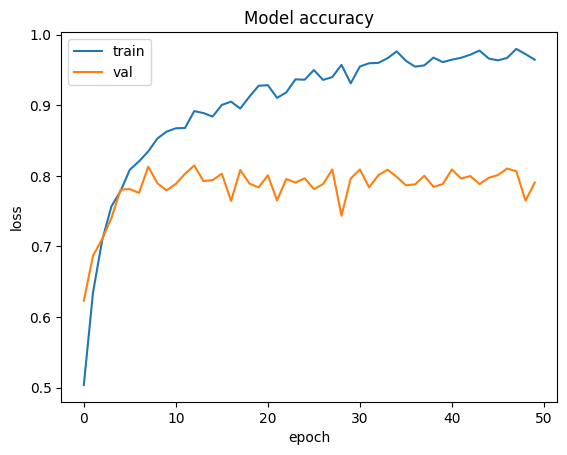

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

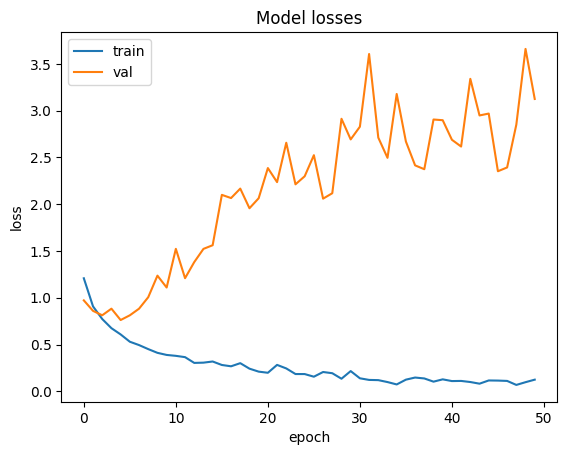

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model losses')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [18]:
#Predicting the test data
test_data = model.evaluate(test_images, test_labels)

94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 106ms/step - accuracy: 0.7798 - loss: 1.5800


In [19]:
from sklearn.metrics import ConfusionMatrixDisplay 
from sklearn import metrics

In [20]:
train_prediction = model.predict(train_images)

print(
    f"Classification report for model {model}:\n"
    f"{metrics.classification_report(train_labels, np.argmax(train_prediction, axis=1))}\n"
)

439/439 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step


W0000 00:00:1715743129.958143      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Classification report for model <Sequential name=sequential, built=True>:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      2191
           1       0.96      0.99      0.97      2271
           2       0.92      0.90      0.91      2404
           3       0.91      0.92      0.91      2512
           4       0.93      0.94      0.93      2274
           5       0.95      0.94      0.94      2382

    accuracy                           0.94     14034
   macro avg       0.94      0.94      0.94     14034
weighted avg       0.94      0.94      0.93     14034




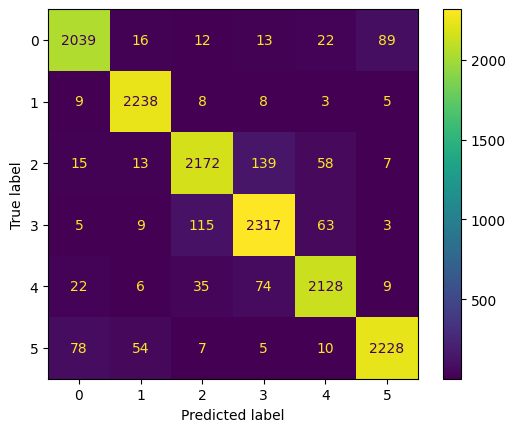

In [21]:
ConfusionMatrixDisplay.from_predictions(train_labels,np.argmax(train_prediction, axis=1)) 
plt.show()


In [22]:
test_prediction = model.predict(test_images)       

print(
    f"Classification report for model {model}:\n"
    f"{metrics.classification_report(test_labels, np.argmax(test_prediction, axis=1))}\n"
)

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step
Classification report for model <Sequential name=sequential, built=True>:
              precision    recall  f1-score   support

           0       0.76      0.74      0.75       437
           1       0.89      0.96      0.93       474
           2       0.77      0.72      0.75       553
           3       0.74      0.76      0.75       525
           4       0.79      0.83      0.81       510
           5       0.82      0.78      0.80       501

    accuracy                           0.80      3000
   macro avg       0.80      0.80      0.80      3000
weighted avg       0.80      0.80      0.80      3000




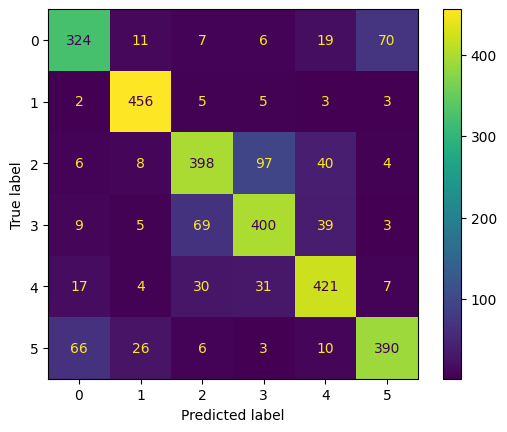

In [23]:
ConfusionMatrixDisplay.from_predictions(test_labels,np.argmax(test_prediction, axis=1)) 
plt.show()


true_prediction is : 2
true_Class_name is : glacier


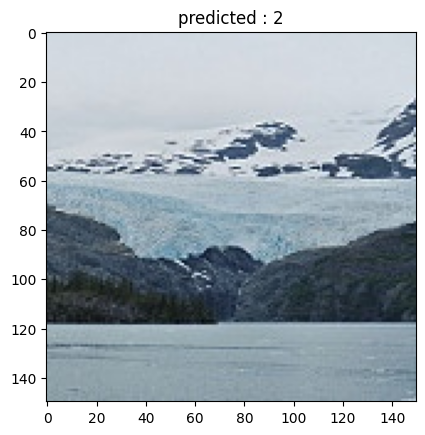

In [24]:
i = np.random.randint(test_images.shape[0])

def pretest(i):
    plt.imshow(test_images[i])                  
    plt.title('predicted : '+ str(np.argmax(test_prediction[i])))
    print('true_prediction is :',test_labels[i])
    print('true_Class_name is :',class_names[test_labels[i]])
      
pretest(i)


Showing random redicted pictures & its predicting category

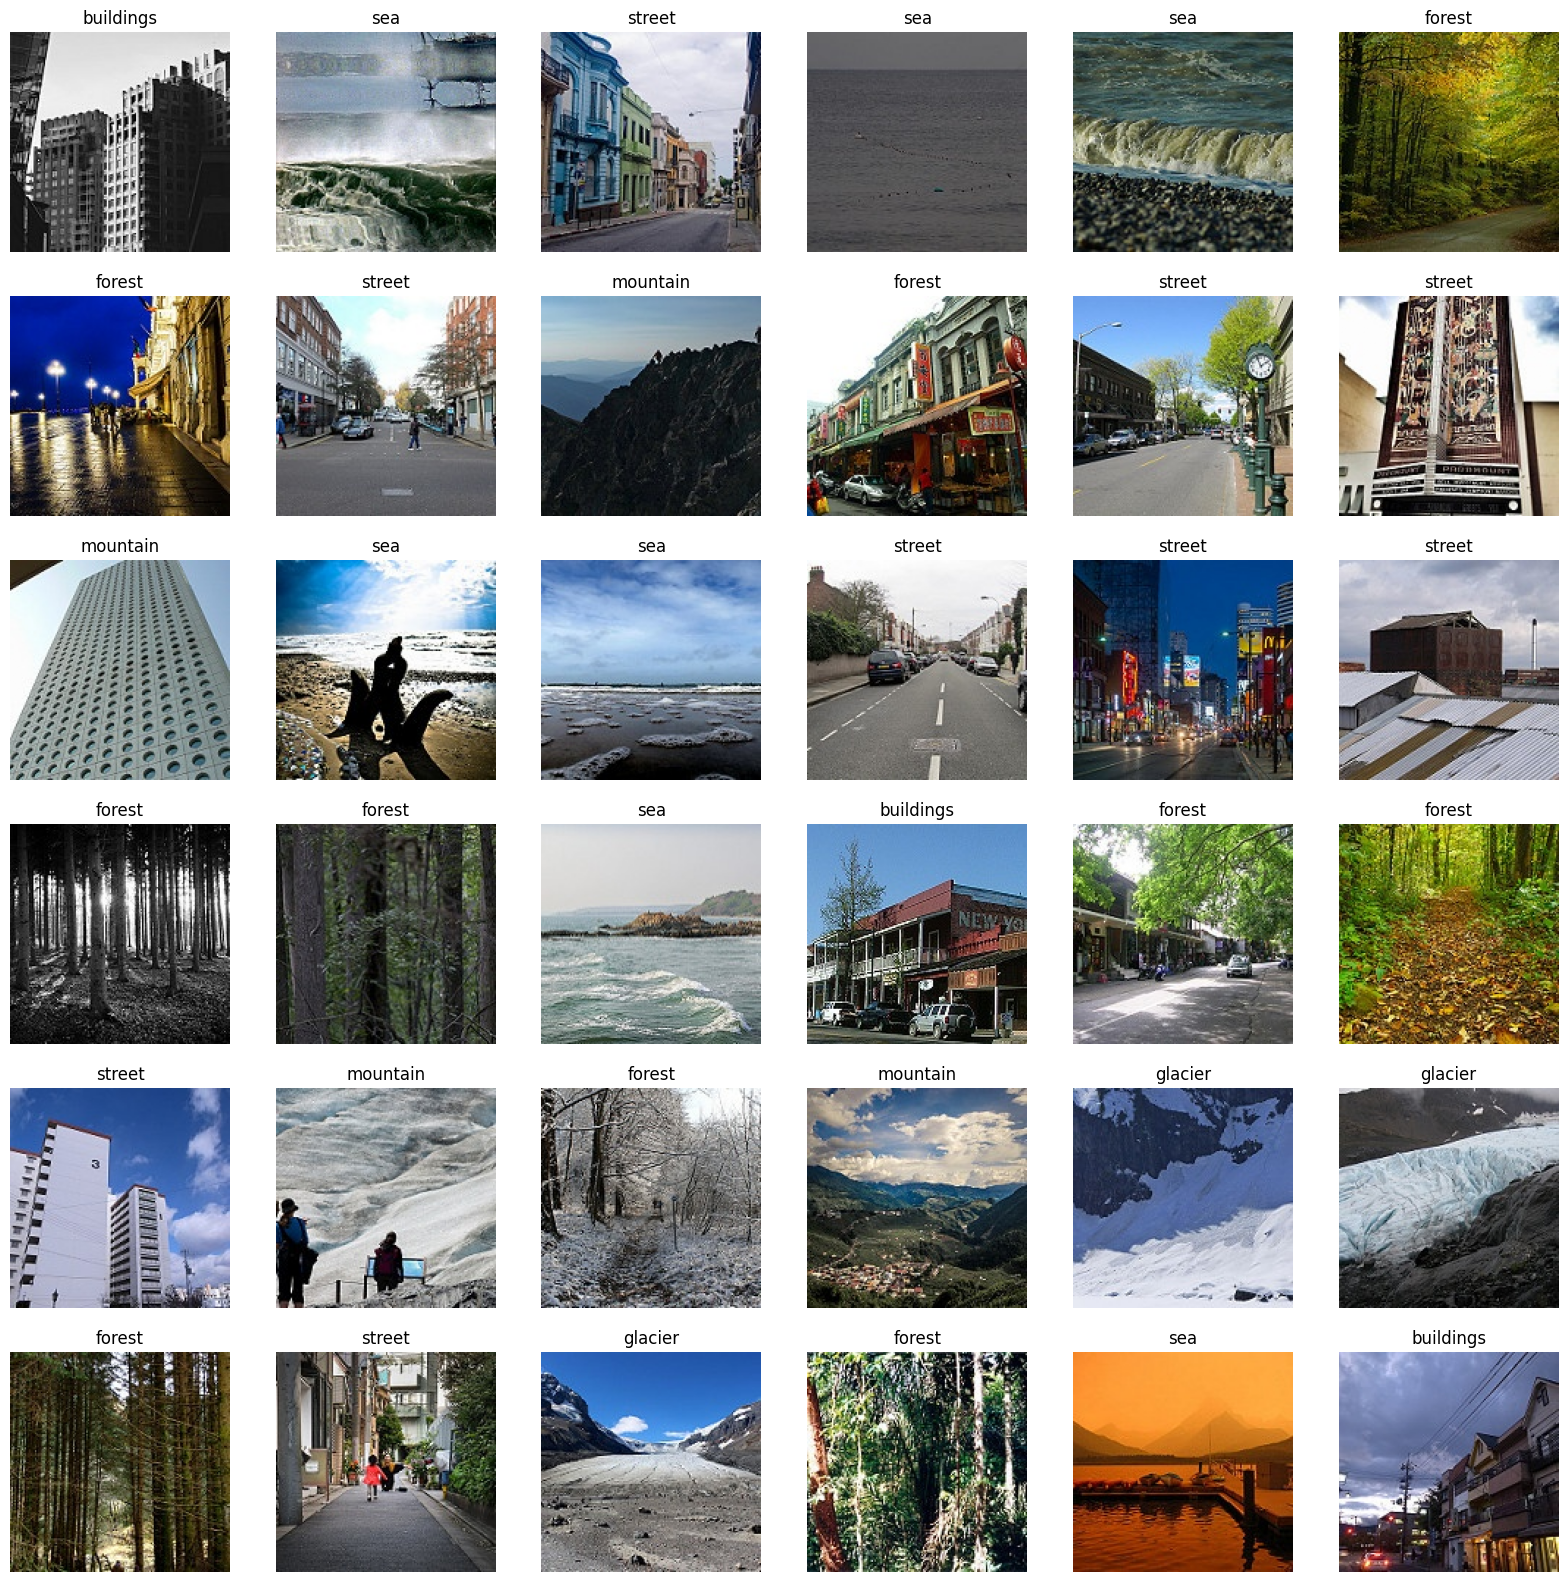

In [25]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(test_images),36))) : 
    plt.subplot(6,6,n+1)
    plt.imshow(test_images[i])    
    plt.axis('off')
    plt.title(class_names[np.argmax(test_prediction[i])])

# 5-Submission

In [26]:
seg_pred_path = '/kaggle/input/intel-image-classification/seg_pred/seg_pred'
seg_pred_images = os.listdir(seg_pred_path)

In [27]:
pred_array = [ ]

for img in os.listdir(seg_pred_path):
    img = cv2.imread(os.path.join(seg_pred_path,img))   
    img = cv2.resize(img,(150,150))
    img = img.reshape(150,150,3)
    pred_array.append(img)

len(pred_array)

7301

In [28]:
pred_array = np.array(pred_array)

In [29]:
pred_array = pred_array / 255.0

In [30]:
pred_array.shape

(7301, 150, 150, 3)

In [31]:
Final_predictions = model.predict(pred_array)

229/229 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step


In [32]:
submission = np.argmax(Final_predictions,axis=1)

In [33]:
len(submission)

7301

In [34]:
i = 1
Final_submission = pd.DataFrame({
    'label' : submission
    
}) 

In [35]:
Final_submission

label
0         4
1         5
2         2
3         0
4         3
...     ...
7296      2
7297      3
7298      3
7299      2
7300      2

[7301 rows x 1 columns]

In [36]:
Final_submission.to_csv("Final_predictions", index=False)